# Estimating intrinsic dimensionalities

TopOMetry involves the estimation of the manifold intrinsic dimensionalities (i.d.) in its workflow. Estimating the i.d. is useful for:

* 1) guessing an optimal number of components to decompose into during eigendecomposition

* 2) setting an adequate number of k-nearest-neighbors (the variance of i.d. estimates will be too large using values of `k` that are too little, and vice-versa)

* 3) understanding the manifold structure better (you can plot i.d. estimates for each sample) 



TopOMetry uses two different approaches to estimate local i.d.: 

* FSA - the manifold-adaptive i.d. estimation originally proposed by Farahmand-Szepesvári-Audibert (FSA) and enhanced by [Benko et al.](http://doi.org/10.7717/peerj-cs.790). It is based on what we call the 'Locality Ratio' - the ratio between the distances to the k- and k/2 ('median') neighbors. This ratio is used in TopOMetry's `bw_adaptive` (bandwidth-adaptive) kernel and can also be visualized for each sample.

* Maximum Likelihood Estimation (MLE) - this method was proposed by [Levina & Bickel](https://proceedings.neurips.cc/paper_files/paper/2004/file/74934548253bcab8490ebd74afed7031-Paper.pdf) and is based on  applying the principle of maximum likelihood to the distances between close neighbors. It is a rock-solid method, proven valuable by time and explored in numerous studies.

i.d. estimates with FSA and MLE are quite inexpensive to compute. They tend to yield very similar results in the vast majority of datasets.

The global i.d. can be estimated by weighting the local estimates obtained by MLE and FSA, or by the 'eigengap' method used during eigendecomposition in TopOMetry.

For this tutorial, we'll compare these two methods in the PBMC3K single-cell RNA-seq dataset. The PBMC3K single-cell RNA-seq dataset is comprised of around 2,700 peripheral blood mononuclear cells (PBMC) from a healthy human donor. As usual, we'll use [scanpy](https://scanpy.readthedocs.io/en/stable/) to assist us handling the sc-data.

We'll see how the i.d. estimated by these methods are linearly correlated in this data.

In [1]:
# Import default libraries
import numpy as np
import topo as tp
import matplotlib.pyplot as plt

# Import scanpy and single-cell data
import scanpy as sc
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

The `IntrinsicDim` class contains all functions we'll need to estimate and visualize i.d. estimates using FSA and MLE:

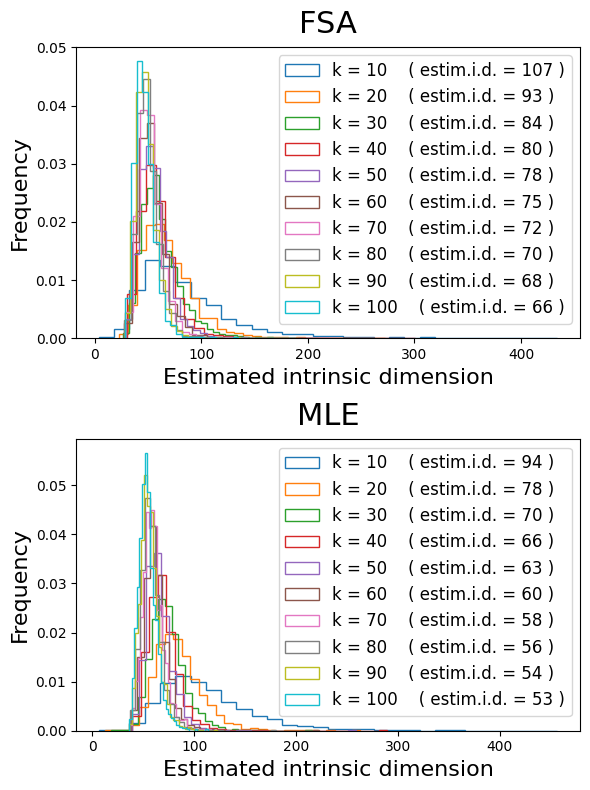

In [2]:
from topo.tpgraph import IntrinsicDim

# Initialize the IntrinsicDim class with default parameters:
id_est = IntrinsicDim(
    methods=['fsa','mle'], # the methods we'll use
    k=range(10, 110, 10), # the number of k-neighbors to test
    backend='hnswlib',  # the approximate kNN backend to use
    metric='euclidean', # the distance metric to use
    n_jobs=-1, # the number of jobs to run in parallel
    plot=True, # whether to plot the results during fit()
    random_state=None) # the random state to use for colors

# Estimate the i.d.
id_est.fit(adata.X)

# Plot the results separately if `plot` was set to False
# id_est.plot_id()

These two distributions look very similar!

Note that the variance of estimates decreases as the size of the neighborhood (number of kNN) increases. Think of it as a lens gradually shifting from local estimates (small k, each region with its very own i.d.) to global estimates (larger k, regions have similar i.d.). 

Overall, these methods agree that the global i.d. of the PBMC3K dataset is somewhere between 50 and 100 dimensions, depending on how we define the size of neighborhoods.

We can see how these estimates are highly correlated:

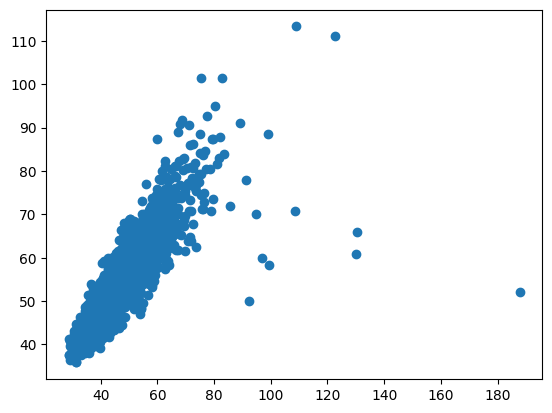

Spearman R correlation: 0.882


In [4]:
from scipy.stats import spearmanr

# Compare the results for 100 k-nearest-neighbors
pbmc_fsa_local = id_est.local_id['fsa']['100']
pbmc_mle_local = id_est.local_id['mle']['100']

corr, _ = spearmanr(pbmc_fsa_local, pbmc_mle_local)

plt.scatter(pbmc_fsa_local, pbmc_mle_local)
plt.show()

print('Spearman R correlation: %.3f' % corr)

Let's now compare the results across all values of k-nearest-neighbors:

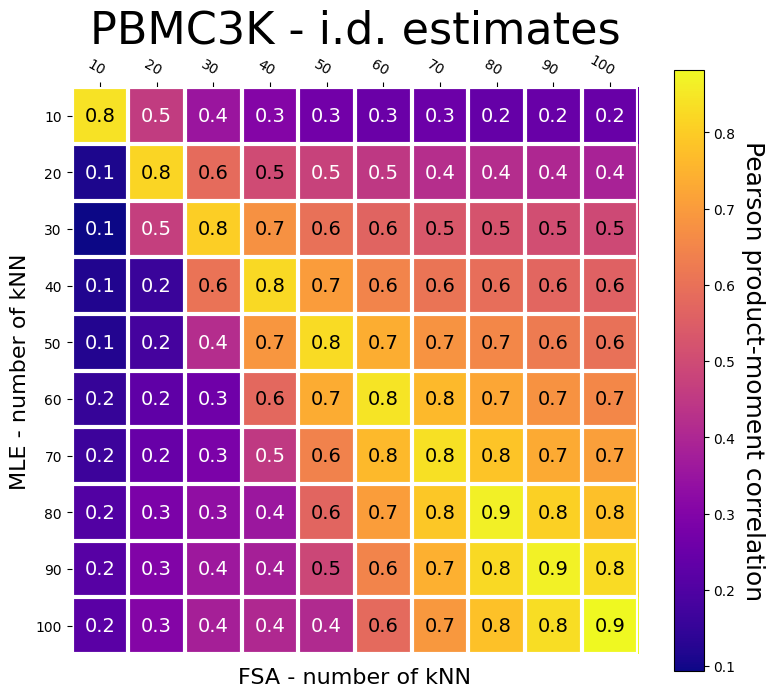

In [5]:
# Compute correlation between the i.d. estimates for each kNN value
keys = []
corr = []
for i_id, k_fsa in enumerate(id_est.local_id['fsa']):
    keys.append(k_fsa)
    for i_id, k_mle in enumerate(id_est.local_id['mle']):
        corr.append(spearmanr(id_est.local_id['fsa'][k_fsa], id_est.local_id['mle'][k_mle])[0])

# Create square array of correlations from the list
cor_array = np.array(corr).reshape((10, 10))
cor_array

# Plot as a heatmap
fig, ax = plt.subplots(figsize=(8,8))

im, cbar = tp.pl.heatmap(cor_array, keys, keys, ax=ax,
                   cmap="plasma", cbarlabel="Pearson product-moment correlation", cbar_fontsize=18, shrink=0.8, cb_pad=0.05)

# Annotated heatmap
texts = tp.pl.annotate_heatmap(im, valfmt="{x:.1f}", textcolors=("white", "black"), an_fontsize=14)

ax.set_xlabel('FSA - number of kNN', fontsize=16)
ax.set_ylabel('MLE - number of kNN', fontsize=16)
ax.set_title('PBMC3K - i.d. estimates', fontsize=32)
fig.tight_layout()
plt.show()

As we can see, their correlation is lower when considering different and small numbers of k-neighbors. The methods agree considerably when using the same number of k-neighbors, or even when using different numbers, given larger neighborhoods.

Next, let's check how these estimates (50-100 dimensions) compare to the eigengap estimate. For this, let's fit a TopOGraph object:

In [6]:
# Create TopOGraph for PBMC3K using 20 kNN
tg = tp.TopOGraph(base_knn=20, 
                        n_eigs=100, # set this to the largest estimate!
                        n_jobs=-1,
                        verbosity=0)

# Run a TopOMetry model for PBMC3K
adata = tp.sc.topological_workflow(
    adata,                  # the anndata object
    tg,                # the TopOGraph object
    kernels=['bw_adaptive'],# the kernel(s) to use
    eigenmap_methods=['DM'],# the eigenmap method(s) to use
    projections=['MAP'],    # the projection(s) to use
    resolution=0.8          # the Leiden clustering resolution
)

Plot the eigengap found during the diffusion map:

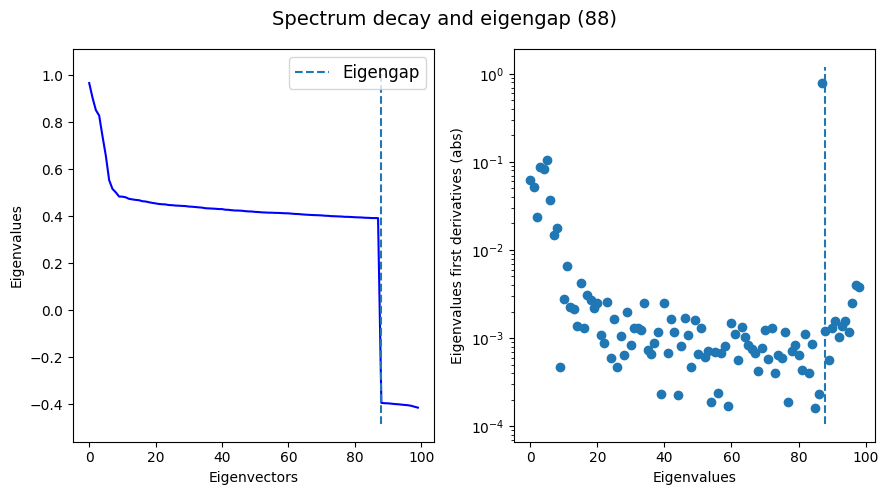

In [7]:
tg.eigenspectrum()

As we can see, our eigengap estimate (82) using k=20 is reasonably similar to what FSA (93) and MLE (79) estimate. 

Next, we might wonder which cell types and neighborhoods have the smallest and largest local i.d.. Let's explore this by adding the local i.d. estimates to our AnnData object:

In [8]:
sc.set_figure_params(scanpy=True, dpi=300, frameon=True, vector_friendly=True, fontsize=14, figsize=(4,4), color_map=None)

# Add the projection results to the AnnData object
proj = tg.ProjectionDict['MAP of bw_adaptive from DM with bw_adaptive']
# with a shorter name for ease
adata.obsm['X_topoMAP'] = proj

# Add some of the i.d. estimates to the AnnData object
adata.obs['FSA i.d. (k = 20)'] = id_est.local_id['fsa']['20']
adata.obs['MLE i.d. (k = 20)'] = id_est.local_id['mle']['20']
adata.obs['FSA i.d. (k = 100)'] = id_est.local_id['fsa']['100']
adata.obs['MLE i.d. (k = 100)'] = id_est.local_id['mle']['100']

And by visualizing a TopOMetry projection using the precomputed labels in scanpy:

/home/davi/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'Cell types'}, xlabel='topoMAP1', ylabel='topoMAP2'>

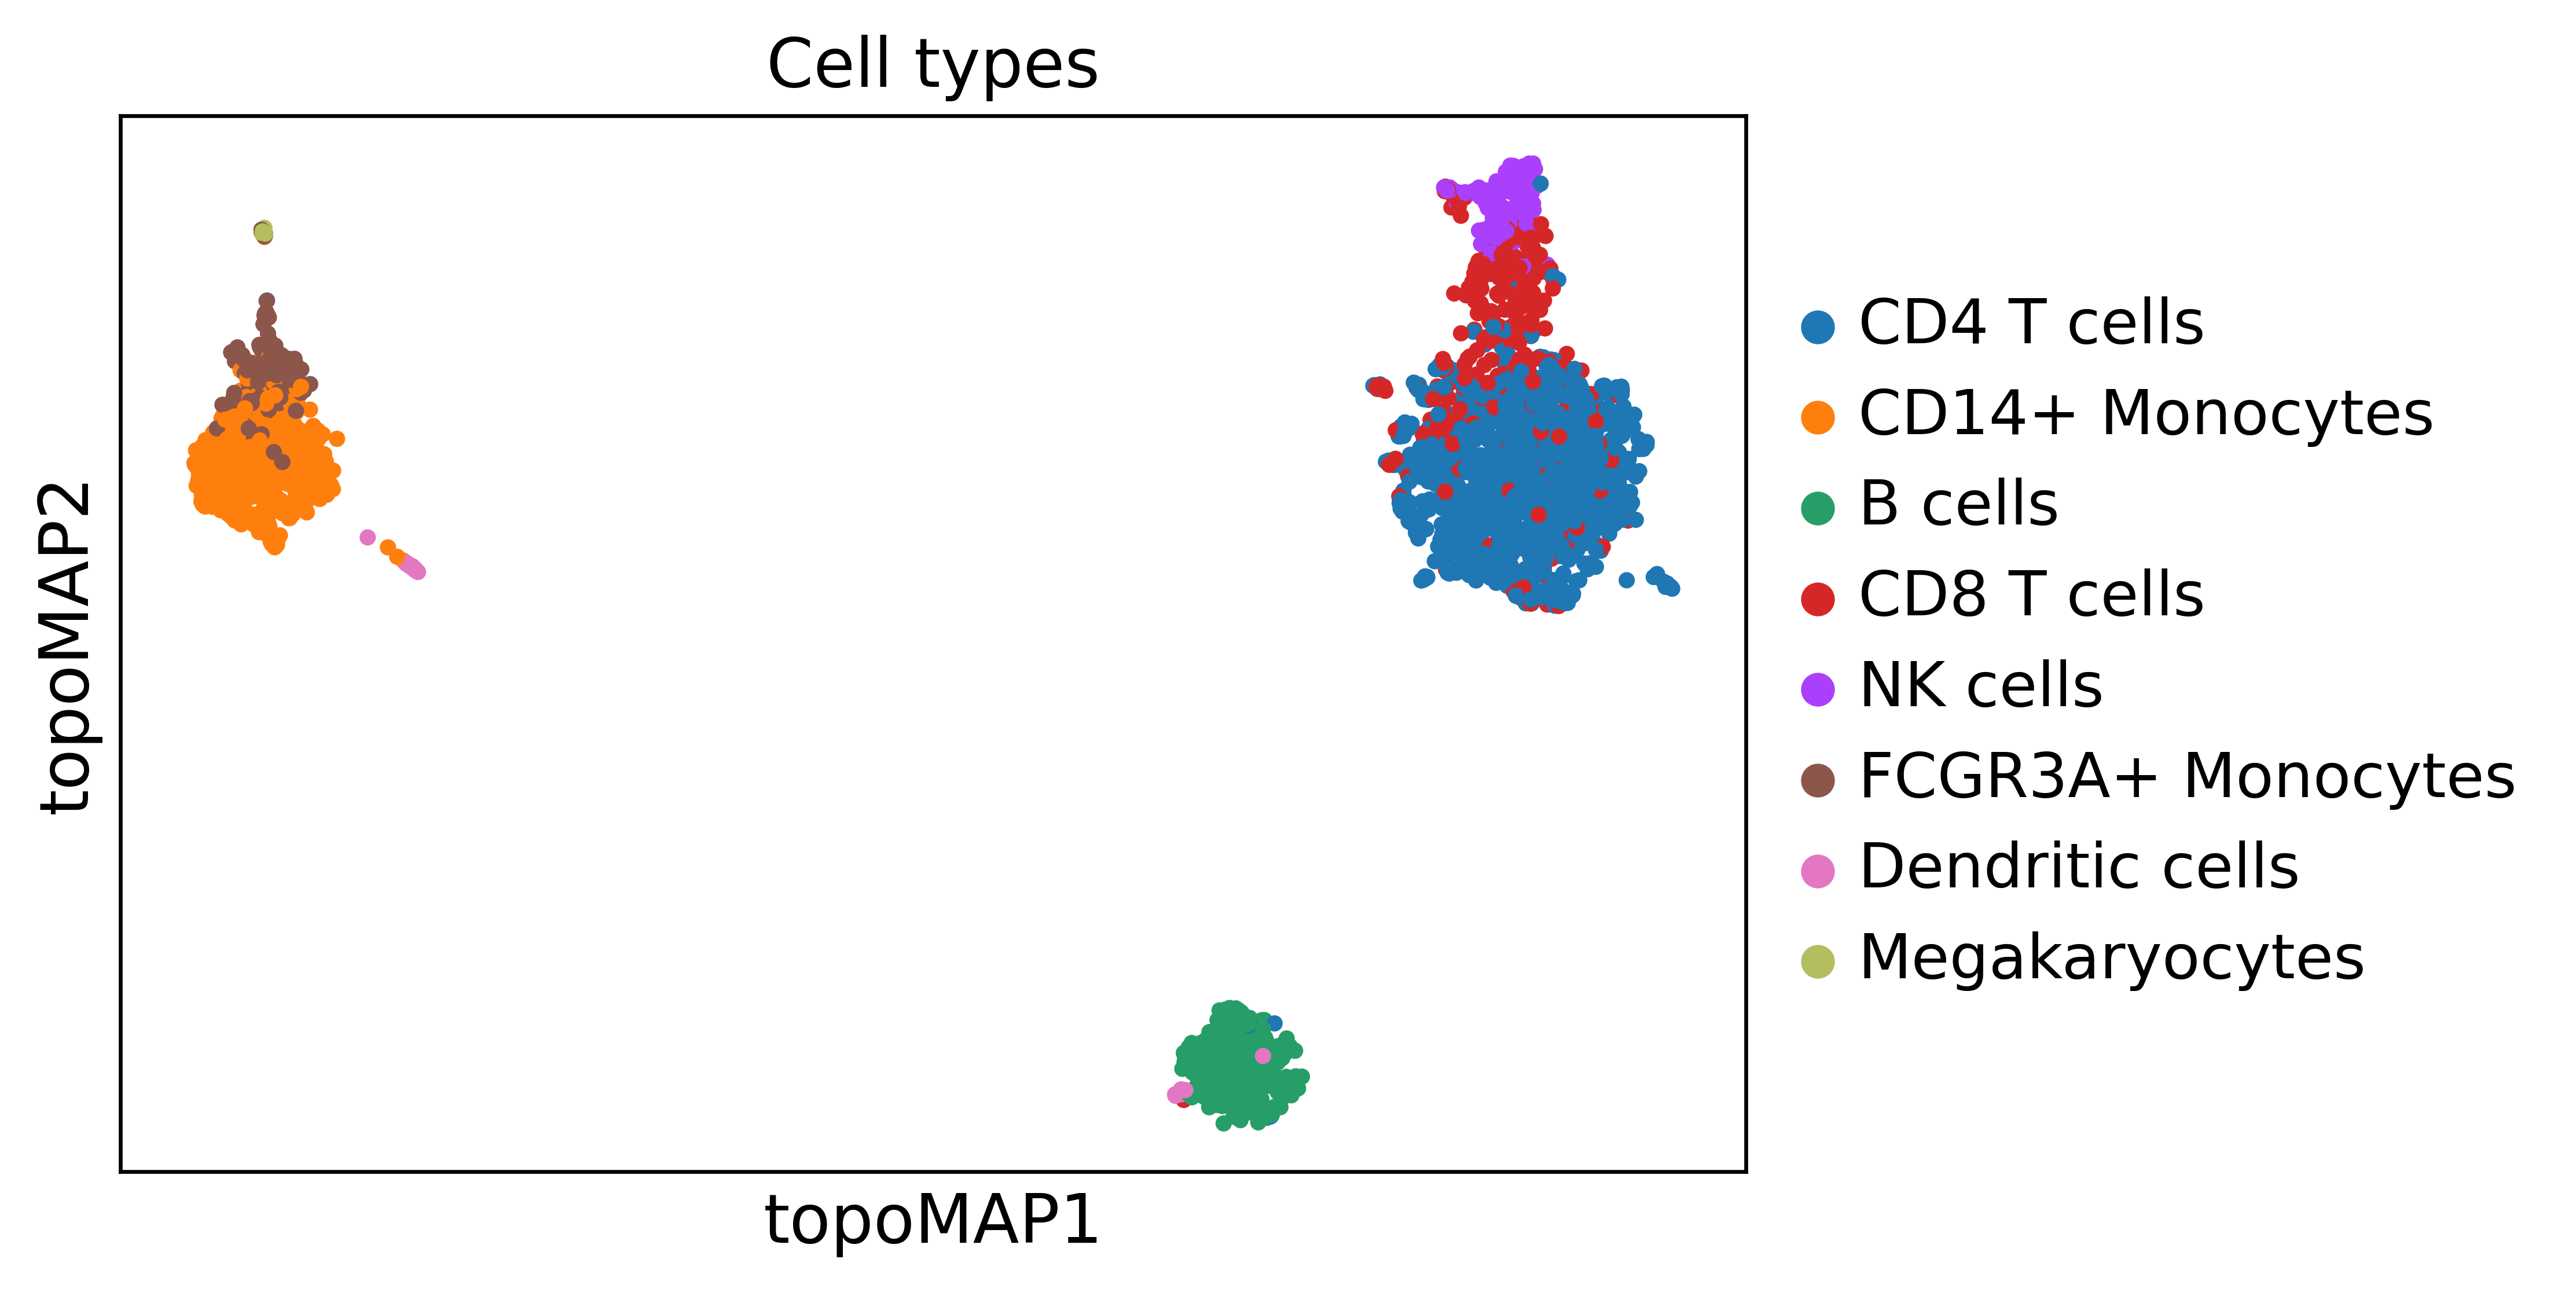

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

adata.obs['Cell types'] = adata.obs['louvain']
ax.set_title('Cell types', fontsize=40)

sc.pl.embedding(adata, basis='topoMAP', ax=ax, color='Cell types', show=False, vmin=50, vmax=100)


How does the i.d. estimate vary across the manifold considering different values of k?

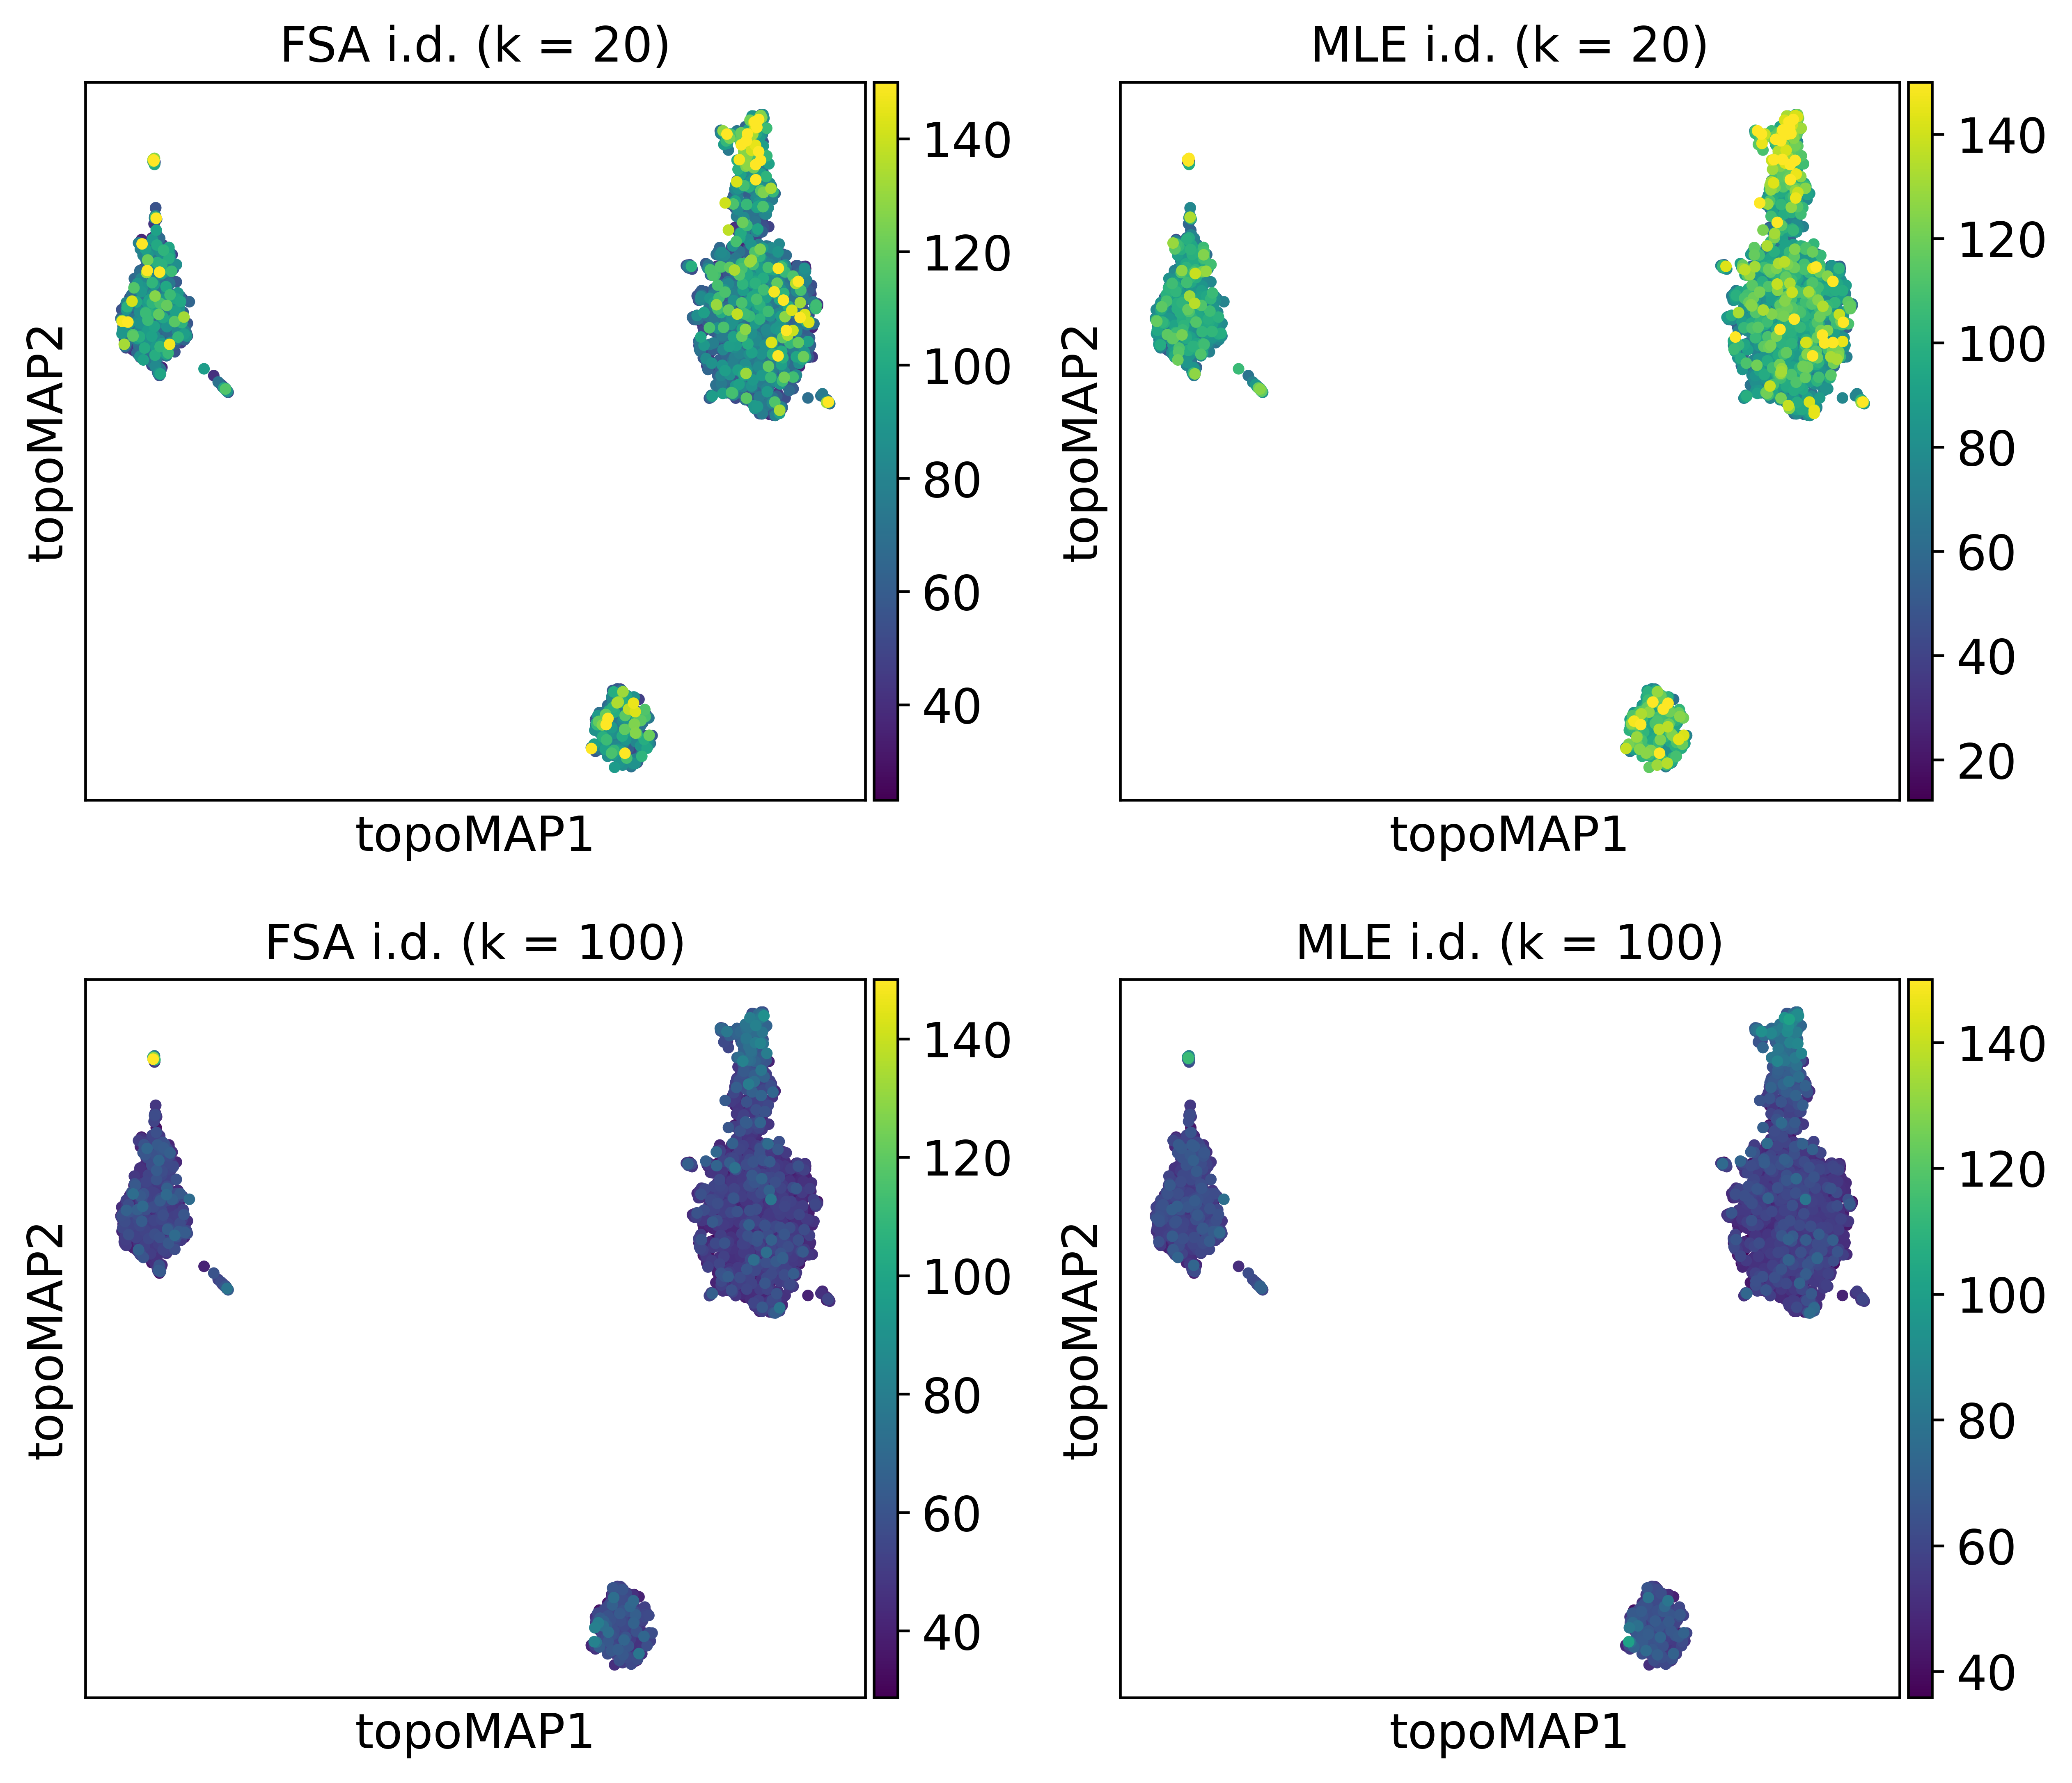

In [11]:
colors = ['FSA i.d. (k = 20)', 'MLE i.d. (k = 20)',
          'FSA i.d. (k = 100)', 'MLE i.d. (k = 100)']

sc.pl.embedding(adata, basis='topoMAP', color=colors, vmax=150, ncols=2)

And across cell types?

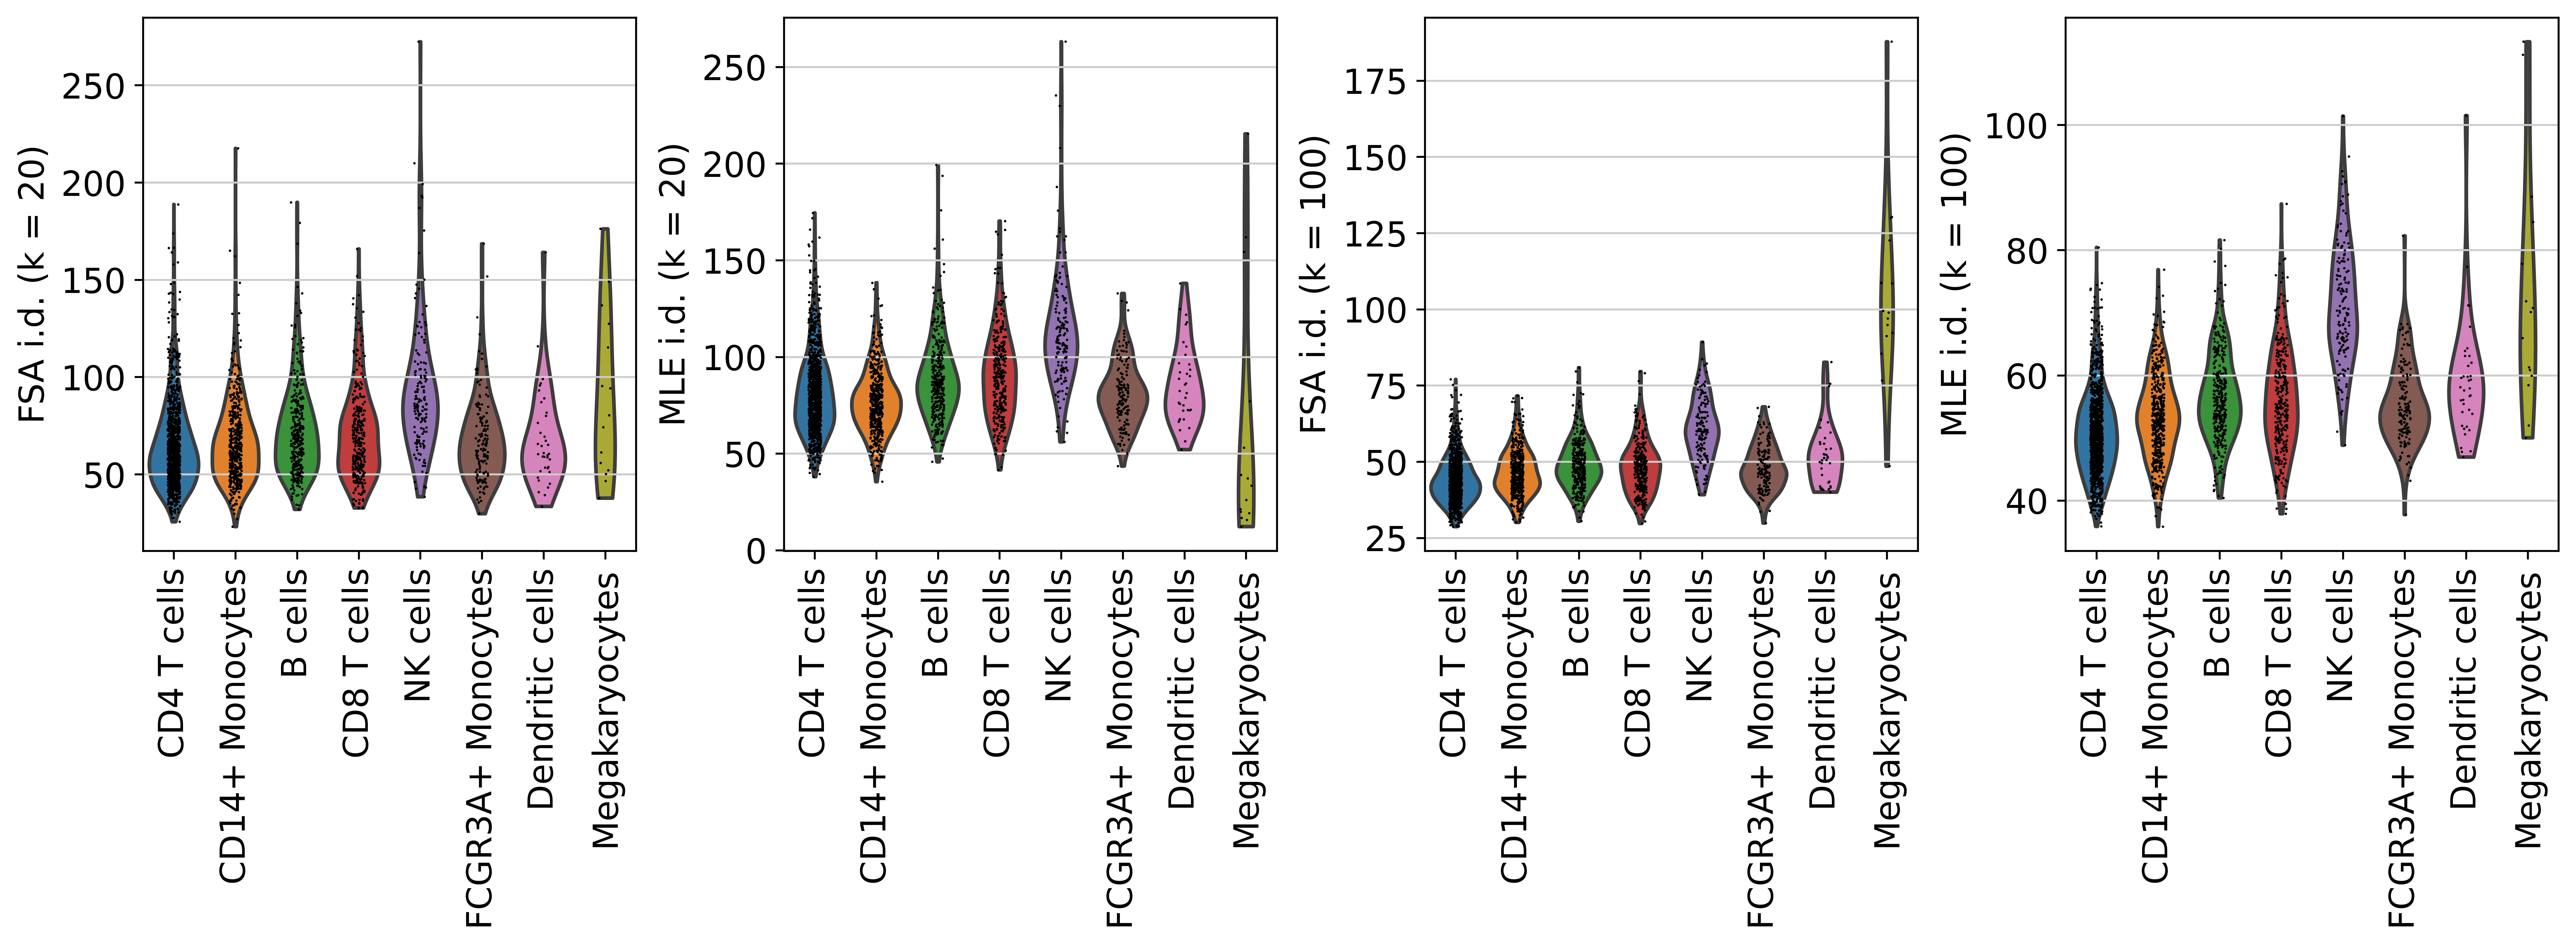

In [12]:
sc.pl.violin(adata, colors, groupby='louvain', rotation = 90, log=False, scale='area', fontsize=10, ncol=1)


As we can see, megakaryocytes (platlet precursors) and NK cells have the highest i.d. estimates. That's curious, isn't it?

That's it for this tutorial! I hope this was informative. Instead of 'estimating' the i.d. by looking at PCA elbow-plots, this shows how you can use various different methods to estimate the dimensionality of your data! 